# Algorithme apprenant

On l'a vu au chapitre précédent, trouver un algorithme permettant d'optimiser la récompense récupérée par un agent évoluant dans un environnement contrôlé est simplement affaire de patience et de construction. Il est en revanche bien plus difficile d'optimiser le comportement d'un agent soumis aux aléas d'un environnement imprévisible.

C'est pourtant ce que tentent de faire les  algorithmes de l'apprentissage par renforcement, dont nous allons donner un aperçu ici.


## Processus de Markov décisionnel et équation de Bellman

La base théorique de l'apprentissage par renforcement est un [processus de Markov décisionnel](https://en.wikipedia.org/wiki/Markov_decision_process), qui correspond à une succession d'étapes décisionnelles, prises dans un réseau (ou graphe), et reliées entre elles par des probabilités.

![Markov Decision Process](fig/Markov_Decision_Process.svg)

On cherche dans ce cas à optimiser les probabilités de chacune des actions de sorte de maximiser la récompense totale, dite récompense à long terme. Cela se fait par la définition d'une fonction de valeur (_value_) $V$ vérifiant l'[équation de Bellman](https://en.wikipedia.org/wiki/Bellman_equation), à la base de la [programmation dynamique](https://en.wikipedia.org/wiki/Dynamic_programming) répondant aux critères de la [théorie des jeux](https://en.wikipedia.org/wiki/Game_theory).

Dit simplement, cette fonction de valeur se met à jour après chaque itération du processus action-réaction de l'agent et de l'environnement, au moment où l'agent récupère sa récompense pour l'action effectuée. On peut effectuer cette mise-à-jour par la connaissance des probabilités de transition entre états. Or, ces probabilités ne sont justement pas connues dans le cas de l'exploration d'un espace probabilistes. Attention à ne pas confondre ces probabilité de transition entre états -- représentées sur la figure ci-dessus et connues -- avec les probabilités de choix des actions, qui elles sont les inconnues du problèmes. 

## Fonction $Q$ et sa mise-à-jour

Dans le cas de l'apprentissage par renforcement, on définit une fonction $Q$, qui donne des valeurs aux transitions entre états $s_{t}$ et $s_{t+1}$ par le fait de l'action $a_{t}$. Pratiquement, cette fonction est un tableau représentant l'ensemble des états (représentés par les lignes du tableau) et actions (colonnes) possibles, chaque nombre pouvant être imaginé comme une préférence à réaliser l'action en regard. L'action sera d'autant plus favorisée que la valeur sera grande. Toutefois ces nombres ne sont pas normalisés, et on ne peut donc pas les interpréter comme des probabilités.

C'est cette fonction que l'on met à jour à l'aide de l'algorithme dit du [Q-learning](https://en.wikipedia.org/wiki/Q-learning)

$$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{current value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{current value}} \bigg) }^{\text{temporal difference}}$$

ou le [SARSA](https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action)

$$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{current value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{Q(s_{t+1}, a_{t+1})}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{current value}} \bigg) }^{\text{temporal difference}}$$

La différence entre les deux approches de mise à jour réside dans le choit de la dernière action $a_{t+1}$, même une fois la partie terminée, pour observer la dernière récompense $r_{t}$ dans le cas du SARSA, alors que le Q-learning maximise la fonction $Q$ correspondant à l'état d'arrivée (cf. le $\max$ dans la mise à jour du Q-learning).

In [1]:
from typing import List, Tuple
import random

from datetime import datetime as dt

import numpy as np
import gymnasium as gym

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
matplotlib.rc('animation', html='jshtml')

from reinforcement_learning import BaseAgent, play_game, learn_game
from reinforcement_learning import display_env, plot_animation

t0 = dt.now()

class QUpdatingAgent(BaseAgent):
    """Base Agent for Q-Learning or SARSA like agents."""
    def __init__(self, env, 
                 epsilon=0.9, # exploration rate
                 alpha=0.05, # learning rate
                 gamma=0.95, # discount factor
                 ):
        self.Q = [[0.0]*env.action_space.n 
                  for _ in range(env.observation_space.n)]
        self.epsilon = float(epsilon)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.possible_actions = list(range(env.action_space.n))
        return None
    def reset(self, state):
        return None
    def choose_action(self, state):
        """Epsilon greedy exploration: 
            - random explroation in self.epsilon% of case, 
            - best previous choice in other case
        """
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(self.possible_actions)
        else:
            action = self.Q[state].index(max(self.Q[state]))
        return action
    def play(self, env, state):
        self.action = self.choose_action(state)
        return self.action
    def update(self,
               actions: List[gym.core.ActType],
               states: List[gym.core.ObsType],
               rewards: List[float],
               infos: List[dict]) -> None:
        for pstate, paction, astate, aaction, reward in zip(
            states[:-2], actions[:-1], states[1:-1], actions[1:], rewards[:-1]):
            self.update_Q(pstate, paction, astate, aaction, reward)
        # the last states must be pseudo-observed as well
        # len(states) ==  len(actions) + 1
        self.update_Q(states[-2], actions[-1], 
                      states[-1], self.choose_action(states[-1]),
                      rewards[-1])
        return None
    def update_Q(self, 
                 previous_state, 
                 previous_action, 
                 actual_state, 
                 actual_action,
                 reward):
        return NotImplementedError


class SARSALearningAgent(QUpdatingAgent):
    """Agent that implements SARSA update algorithm."""
    def update_Q(self, ps, pa, ns, na, r):
        """SARSA update"""
        self.Q[ps][pa] = self.Q[ps][pa] + self.alpha * (
            r + self.gamma * self.Q[ns][na] - self.Q[ps][pa])
        return None


class QLearningAgent(QUpdatingAgent):
    """Agent that implements Q-learning update algorithm."""
    def update_Q(self, ps, pa, ns, na, r):
        """Q-learning update"""
        self.Q[ps][pa] = self.Q[ps][pa] + self.alpha * (
            r + self.gamma * max(self.Q[ns]) - self.Q[ps][pa])
        return None


def print_Q(agent):
    """Display the Q matrix in a fancy format."""
    Q_string = "[" + " "*13
    Q_string += ", ".join(f"action {i:3}"
                          for i in range(len(agent.Q[0])))
    Q_string += "\n"
    for state_id, line in enumerate(agent.Q):
        Q_string += f"state {state_id:3} -> ["
        Q_string += ", ".join(f"{q:10.2f}" for q in line)
        Q_string += "],\n"
    Q_string = Q_string[:-1] + "\n]"
    print(Q_string)
    return None

Instancion un plateau de jeu construit au hasard. Il n'est pas glissant.

In [2]:
# FrozenLake-v1 gym environment
['SFFF', 'FFFF', 'FFHF', 'HFFG']
env = gym.make("FrozenLake-v1",
               desc=['SFFF', 'FFFF', 'FFHF', 'HFFG'],
               render_mode="rgb_array",
               is_slippery=False)
env.reset()
_ = display_env(env)

Au début de l'entraînement, la fonction $Q$ est instanciée avec tous ses coefficients nuls. Tant qu'une seule partie n'a pas été gagnée, tous ses coefficients resteront nuls, comme on peut le voir ci-dessous avec la matrice $Q$ juste avant et juste après l'apprentissge de la première partie gagnée.

In [3]:
agent = SARSALearningAgent(env)

state, info = env.reset()
while True:
    actions, states, rewards, infos, frames = play_game(env, agent)
    if rewards[-1] == 1.0:
        break
    agent.update(actions, states, rewards, infos)

print_Q(agent)

agent.update(actions, states, rewards, infos)

print_Q(agent)

[             action   0, action   1, action   2, action   3
state   0 -> [      0.00,       0.00,       0.00,       0.00],
state   1 -> [      0.00,       0.00,       0.00,       0.00],
state   2 -> [      0.00,       0.00,       0.00,       0.00],
state   3 -> [      0.00,       0.00,       0.00,       0.00],
state   4 -> [      0.00,       0.00,       0.00,       0.00],
state   5 -> [      0.00,       0.00,       0.00,       0.00],
state   6 -> [      0.00,       0.00,       0.00,       0.00],
state   7 -> [      0.00,       0.00,       0.00,       0.00],
state   8 -> [      0.00,       0.00,       0.00,       0.00],
state   9 -> [      0.00,       0.00,       0.00,       0.00],
state  10 -> [      0.00,       0.00,       0.00,       0.00],
state  11 -> [      0.00,       0.00,       0.00,       0.00],
state  12 -> [      0.00,       0.00,       0.00,       0.00],
state  13 -> [      0.00,       0.00,       0.00,       0.00],
state  14 -> [      0.00,       0.00,       0.00,       0

Dès qu'au moins une partie est réussie, la matrice `agent.Q` commence à se structurer, afin d'apprendre les meilleurs coups à jouer en partant de la case d'arrivée et en remontant petit à petit au gré des réussites jusqu'à structurer tout un (ou plusieurs) parcours depuis la ligne de départ. C'est donc une forme de [règles d'induction renversée](https://en.wikipedia.org/wiki/Backward_induction).

```{admonition} Apprendre de ses échecs également
:class: hint
Dans notre jeu, la seule récompense est positive, et n'arrive que lorsque le pion arrive sur la case du trésor. On peut tout à fait inventer des jeux où il existerait une récompense négative, qui pénaliserait les échecs.

En fait les règles de l'apprentissage par renforcement sont très permissives.
```

Jouons maintenant un grand nombre de parties, et apprenant de chacune, .

In [4]:
learn_game(env, agent, nb_total_games=1000)
print_Q(agent)

[             action   0, action   1, action   2, action   3
state   0 -> [      0.06,       0.05,       0.09,       0.06],
state   1 -> [      0.06,       0.07,       0.12,       0.08],
state   2 -> [      0.08,       0.12,       0.18,       0.12],
state   3 -> [      0.12,       0.28,       0.20,       0.21],
state   4 -> [      0.05,       0.02,       0.06,       0.06],
state   5 -> [      0.04,       0.04,       0.10,       0.08],
state   6 -> [      0.07,       0.00,       0.27,       0.12],
state   7 -> [      0.12,       0.52,       0.28,       0.21],
state   8 -> [      0.02,       0.00,       0.02,       0.04],
state   9 -> [      0.02,       0.04,       0.00,       0.07],
state  10 -> [      0.00,       0.00,       0.00,       0.00],
state  11 -> [      0.00,       1.00,       0.61,       0.28],
state  12 -> [      0.00,       0.00,       0.00,       0.00],
state  13 -> [      0.00,       0.03,       0.16,       0.02],
state  14 -> [      0.01,       0.10,       0.69,       0

Puis analysons notre modèle d'agent, en comptant le nombre de parties réussies.

In [5]:
final_rewards = []
for _ in range(100):
    actions, states, rewards, infos, frames = play_game(env, agent)
    final_rewards.append(rewards[-1])
print("{:,}/100 parties gagnées".format(int(sum(final_rewards))))

26/100 parties gagnées


Voyons l'évolution si l'on rajoute encore beaucoup de parties d'entraînement.

In [6]:
learn_game(env, agent, nb_total_games=5000)
print_Q(agent)

[             action   0, action   1, action   2, action   3
state   0 -> [      0.08,       0.08,       0.11,       0.08],
state   1 -> [      0.09,       0.09,       0.14,       0.11],
state   2 -> [      0.11,       0.11,       0.18,       0.15],
state   3 -> [      0.14,       0.23,       0.18,       0.18],
state   4 -> [      0.08,       0.06,       0.09,       0.09],
state   5 -> [      0.08,       0.09,       0.11,       0.10],
state   6 -> [      0.09,       0.00,       0.24,       0.14],
state   7 -> [      0.13,       0.41,       0.25,       0.19],
state   8 -> [      0.08,       0.00,       0.11,       0.08],
state   9 -> [      0.07,       0.22,       0.00,       0.09],
state  10 -> [      0.00,       0.00,       0.00,       0.00],
state  11 -> [      0.00,       1.00,       0.48,       0.25],
state  12 -> [      0.00,       0.00,       0.00,       0.00],
state  13 -> [      0.00,       0.18,       0.52,       0.11],
state  14 -> [      0.19,       0.38,       1.00,       0

In [7]:
final_rewards = []
for _ in range(100):
    actions, states, rewards, infos, frames = play_game(env, agent)
    final_rewards.append(rewards[-1])
print("{:,}/100 parties gagnées".format(int(sum(final_rewards))))

20/100 parties gagnées


### Carte aléatoire

Pour conclure, regardons comment se comporte notre algorithme dans le cas d'un environnement aléatoire, en activant l'option de case glissante, et en réentraînant tout le modèle.

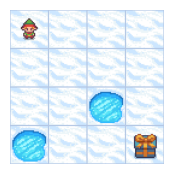

In [8]:
envslippery = gym.make("FrozenLake-v1",
                       desc=['SFFF', 'FFFF', 'FFHF', 'HFFG'],
                       render_mode="rgb_array",
                       is_slippery=True)
envslippery.reset()
_ = display_env(envslippery)

In [9]:
agent = agent = SARSALearningAgent(envslippery)

final_rewards = []
for _ in range(1000):
    actions, states, rewards, infos, frames = play_game(envslippery, agent)
    final_rewards.append(rewards[-1])
print("{:,}/1000 parties gagnées avant entraînement".format(int(sum(final_rewards))))

83/1000 parties gagnées avant entraînement


In [10]:
learn_game(envslippery, agent, nb_total_games=10000)
print_Q(agent)

[             action   0, action   1, action   2, action   3
state   0 -> [      0.05,       0.05,       0.05,       0.05],
state   1 -> [      0.05,       0.06,       0.07,       0.06],
state   2 -> [      0.07,       0.08,       0.09,       0.09],
state   3 -> [      0.12,       0.12,       0.13,       0.11],
state   4 -> [      0.04,       0.05,       0.05,       0.05],
state   5 -> [      0.05,       0.06,       0.06,       0.06],
state   6 -> [      0.04,       0.08,       0.07,       0.10],
state   7 -> [      0.18,       0.16,       0.21,       0.11],
state   8 -> [      0.02,       0.03,       0.03,       0.04],
state   9 -> [      0.08,       0.06,       0.08,       0.03],
state  10 -> [      0.00,       0.00,       0.00,       0.00],
state  11 -> [      0.35,       0.47,       0.48,       0.17],
state  12 -> [      0.00,       0.00,       0.00,       0.00],
state  13 -> [      0.08,       0.16,       0.19,       0.14],
state  14 -> [      0.16,       0.51,       0.51,       0

In [11]:
final_rewards = []
for _ in range(1000):
    actions, states, rewards, infos, frames = play_game(envslippery, agent)
    final_rewards.append(rewards[-1])
print("{:,}/1000 parties gagnées après entraînement".format(int(sum(final_rewards))))

127/1000 parties gagnées après entraînement


In [12]:
tet = dt.now() - t0
tet = tet.total_seconds()
print("Temps total d'éxécution {:.2f}s".format(tet))
print("Dernière modification {}".format(dt.now().strftime("%d/%m/%Y")))

Temps total d'éxécution 737.22s
Dernière modification 22/02/2024
